 DCT based compression and reconstruction

In [2]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import imageio as iio

from numpy import pi
from numpy import r_

Display image

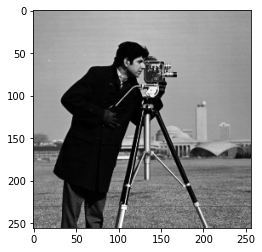

In [3]:
img = iio.imread("cameraman.tif").astype(float)
#print(img.shape)

f = plt.figure()
plt.imshow(img,cmap='gray')

Define 2D DCT and IDCT

In [4]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a.T, norm='ortho' ).T, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a.T , norm='ortho').T,norm='ortho')

Perform a blockwise DCT

In [5]:
imsize = img.shape
dct = np.zeros(imsize)

for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        dct[i:i+8,j:j+8] = dct2( img[i:i+8,j:j+8] )

Extract 8x8 block and look at its DCT coefficients

Text(0.5, 1.0, 'An 8x8 DCT block')

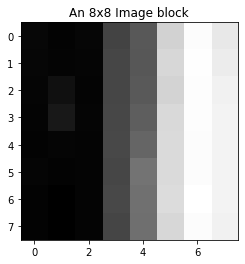

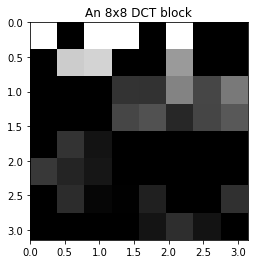

In [6]:
pos = 128

# Extract a block from image
plt.figure()
plt.imshow(img[pos:pos+8,pos:pos+8],cmap='gray')
plt.title( "An 8x8 Image block")

# Display the dct of that block
plt.figure()
plt.imshow(dct[pos:pos+8,pos:pos+8],cmap='gray',vmax= np.max(dct)*0.01,vmin = 0, extent=[0,pi,pi,0])
plt.title( "An 8x8 DCT block")

Display all DCT blocks

Text(0.5, 1.0, '8x8 DCTs of the image')

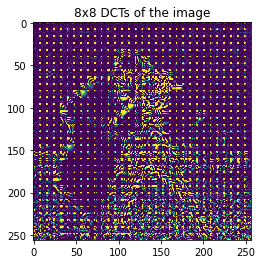

In [7]:
# Display entire DCT
plt.figure()
plt.imshow(dct,vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "8x8 DCTs of the image")

Threshold DCT coefficients

Keeping only 12.638855% of the DCT coefficients


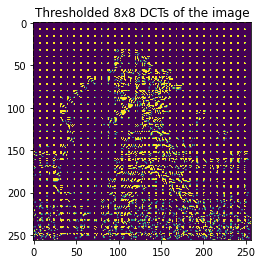

In [8]:
# Threshold
thresh = 0.012
dct_thresh = dct * (abs(dct) > (thresh*np.max(dct)))


plt.figure()
plt.imshow(dct_thresh,vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "Thresholded 8x8 DCTs of the image")

percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)

print ("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))

Compare DCT compressed image with original

Text(0.5, 1.0, 'Comparison between original and DCT compressed images')

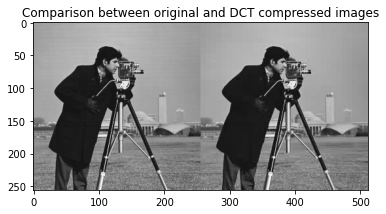

In [9]:
img_dct = np.zeros(imsize)

for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        img_dct[i:(i+8),j:(j+8)] = idct2( dct_thresh[i:(i+8),j:(j+8)] )
        
        
plt.figure()
plt.imshow( np.hstack( (img, img_dct) ) ,cmap='gray')
plt.title("Comparison between original and DCT compressed images" )

JPEG compression

In [10]:
img2 = iio.imread("lena_512.bmp").astype(float)
height  = len(img2[1]) #one column of image
width = len(img2[0]) # one row of image

Quality Factor 

In [11]:
QF1 = 50
QF2 = 75

Quality Matrix Formulation

In [12]:
Q50 = [ [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [ 14, 13, 16, 24, 40, 57, 69, 56],
        [ 14, 17, 22, 29, 51, 87, 80, 62],
        [ 18, 22, 37, 56, 68, 109, 103, 77],
        [ 24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]]

#Quality Matrix for QF1  
if QF1 > 50:
    QM1 = (Q50*(np.ones((8,8)) * ((100 - QF1) / 50))).round().astype(np.int32) 
else:
    if QF1 < 50:
        QM1 = (Q50*(np.ones((8,8)) * (50 / QF1))).round().astype(np.int32)
        QM1 = (QM1).astype(int)
    else:
        if QF1 == 50:
            QM1 = Q50

QM1 = np.array((QM1), dtype=np.float32)

# Quality Matrix for QF2

if QF2 > 50:
    QM2 = (Q50*(np.ones((8,8)) * ((100 - QF2) / 50))).round().astype(np.int32)
else:
    if QF2 < 50:
        QM2 = (Q50*(np.ones((8,8)) * (50 / QF2))).round().astype(np.int32)
    else:
        if QF2 == 50:
            QM2 = Q50

QM2 = np.array((QM2), dtype=np.float32)

In [13]:
dct_domain = np.zeros((img2.shape))
dct_quantized = np.zeros((img2.shape))
dct_quantized_coeff = np.zeros((64,len(np.arange(1,width,8)) * len(np.arange(1,height,8)))) 
#print(dct_quantized_coeff.shape)
dct_dequantized = np.zeros((img2.shape))
dct_restored = np.zeros((img2.shape))
dct_domain2 = np.zeros((img2.shape))
dct_quantized2 = np.zeros((img2.shape))
dct_quantized2_coeff = np.zeros((64,len(np.arange(1,width,8)) * len(np.arange(1,height,8))))
#print(dct_quantized2_coeff.shape)

Subtracting each image pixel value by 128

In [14]:
im = img2 -128

ZigZag function

In [15]:
def zigzag(input): 
# initializing the variables

    h = 0
    v = 0
    vmin = 0
    hmin = 0
    vmax = input.shape[0]
    hmax = input.shape[1]
    i = 0
    output = np.zeros((vmax * hmax))
    
    while ((v < vmax) and (h < hmax)):

        if ((h + v) % 2) == 0:
            if (v == vmin):
                output[i] = input[v,h]
                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            else:
                if ((h == hmax-1) and (v < vmax)):
                    output[i] = input[v,h]
                    v = v + 1
                    i = i + 1
                else:
                    if ((v > vmin) and (h < hmax-1)):
                        output[i] = input[v,h]
                        v = v - 1
                        h = h + 1
                        i = i + 1
        else:
            if ((v == vmax-1) and (h <= hmax-1)):
                output[i] = input[v,h]
                h = h + 1
                i = i + 1
            else:
                if (h == hmin):
                    output[i] = input[v,h]
                    if (v == vmax-1):
                        h = h + 1
                    else:
                        v = v + 1
                    i = i + 1
                else:
                    if ((v < vmax-1) and (h > hmin)):
                        output[i] = input[v,h]
                        v = v + 1
                        h = h - 1
                        i = i + 1
        if ((v == vmax-1) and (h == hmax-1)):
            output[i] = input[v,h]
            break

    
    return output

Jpeg Encoding QF1

In [16]:
k = 0
for i1 in np.arange(0,width,8).reshape(-1):
    for i2 in np.arange(0,height,8).reshape(-1):
        zBLOCK = im[i1:i1+8, i2:i2 +8]
      
# Forward Discrete Cosine Transform
        win1 = dct2(zBLOCK)
        dct_domain[i1:i1+8, i2:i2 +8] = win1
       
# Quantization of the DCT coefficients

        win2 = (win1 / QM1).round().astype(np.int32)
        dct_quantized[i1:i1+8, i2:i2 +8] = win2
        dct_quantized_coeff[:,k] = zigzag(win2)
        k = k + 1

Jpeg Decoding

In [17]:
for i1 in np.arange(0,width,8).reshape(-1):
    for i2 in np.arange(0,height,8).reshape(-1):
        win2 = dct_quantized[i1:i1+8, i2:i2 +8]
        
# Dequantization of DCT Coefficients
        win3 = np.multiply(win2,QM1)
        dct_dequantized[i1:i1+8, i2:i2 +8] = win3
        
# Inverse DISCRETE COSINE TRANSFORM
        win4 = idct2(win3)
        dct_restored[i1:i1+8, i2:i2 +8] = win4

I_reconst = dct_restored

Text(0.5, 1.0, 'The image after decoding')

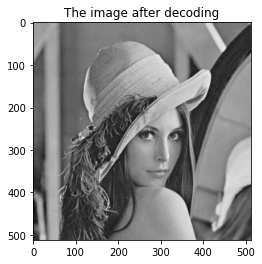

In [18]:
plt.imshow(I_reconst,cmap='gray')
plt.title( "The image after decoding")

Jpeg Encoding QF2

In [19]:
k = 0
for i1 in np.arange(0,width,8).reshape(-1):
    for i2 in np.arange(0,height,8).reshape(-1):
        zBLOCK = im[i1:i1+8, i2:i2 +8]
        #----------------------------------------------------------
# Forward Discrete Cosine Transform
        win5 = dct2(zBLOCK)
        dct_domain2[i1:i1+8, i2:i2 +8] = win5
        #-----------------------------------------------------------
# Quantization of the DCT coefficients
        #print(win1)
        win6 = (win5 / QM2).round().astype(np.int32)
        dct_quantized2[i1:i1+8, i2:i2 +8] = win6
        dct_quantized2_coeff[:,k] = zigzag(win6)
        k = k + 1

Text(0.5, 1.0, 'DCT 1st quant')

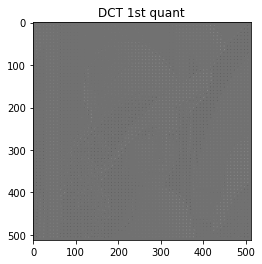

In [20]:
plt.imshow(dct_quantized,cmap='gray')
plt.title( "DCT 1st quant")

Text(0.5, 1.0, 'DCT 2nd quant')

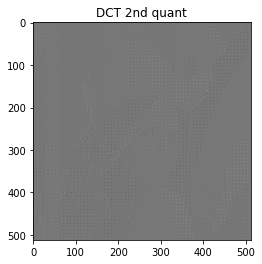

In [21]:
plt.imshow(dct_quantized2,cmap='gray')
plt.title( "DCT 2nd quant")

Global analysis of DCT coefficients

In [22]:
min_dct = min(np.min(dct_quantized[:]),np.min(dct_quantized2[:]))
max_dct = max(np.max(dct_quantized[:]),np.max(dct_quantized2[:]))
print(min_dct)
print(max_dct)
x_bin = np.arange(min_dct,max_dct)




-94.0
107.0


Comparison of histograms of all DCT coefficients of the first and second compressed images

P.s it takes ~6min to compute it.

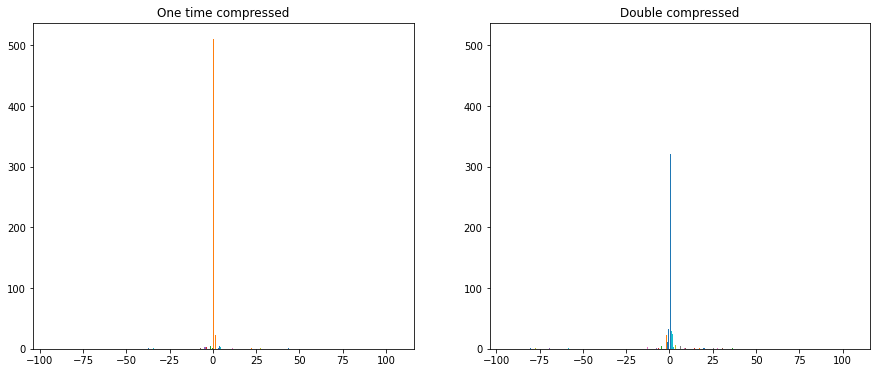

In [23]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.hist(dct_quantized, x_bin)
ax1.set_title("One time compressed")
ax2.hist(dct_quantized2, x_bin)
ax2.set_title("Double compressed")

plt.show()

Comparison of histograms of first 10 DCT coefficients of the first and second compressed images

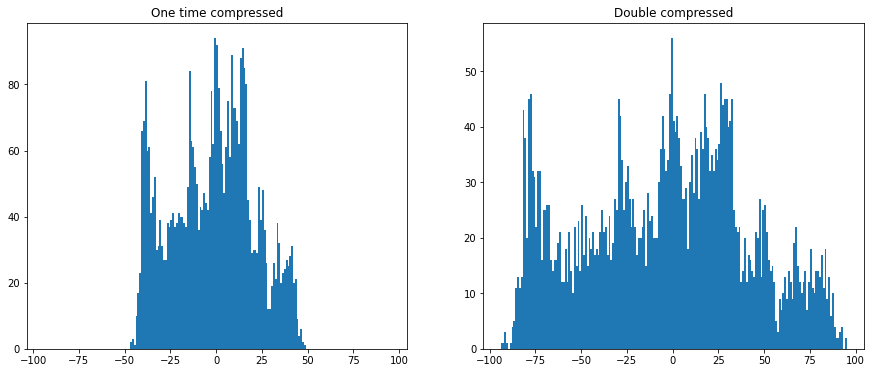

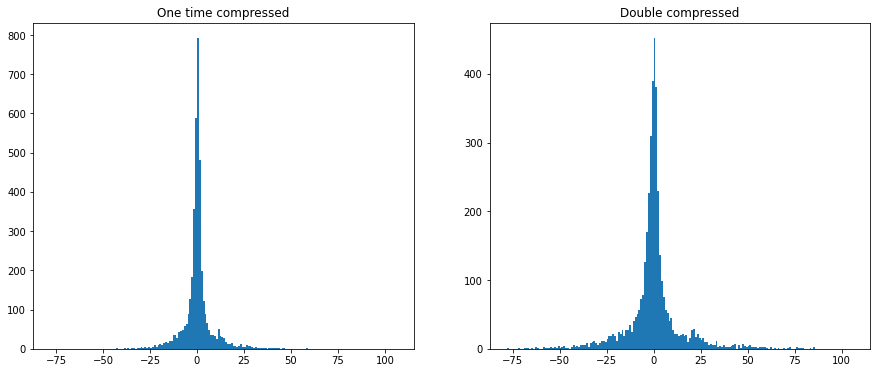

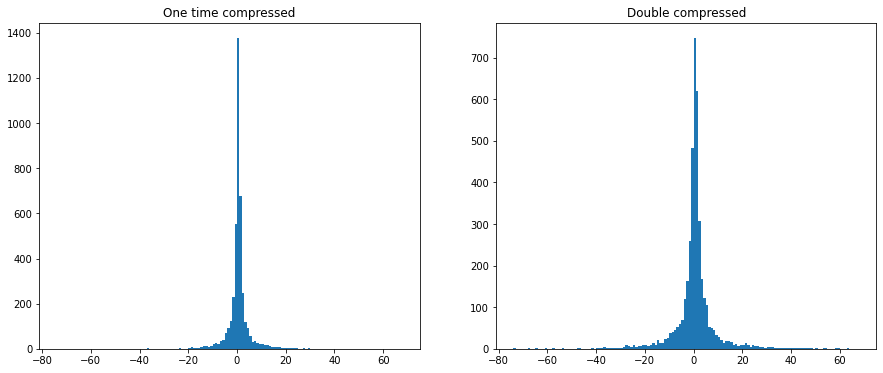

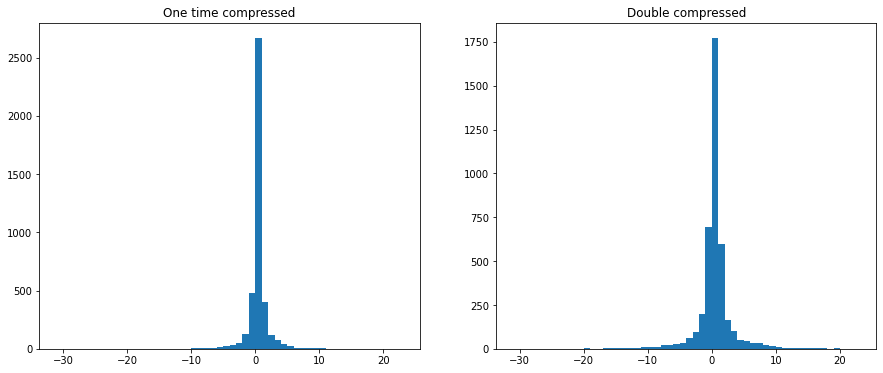

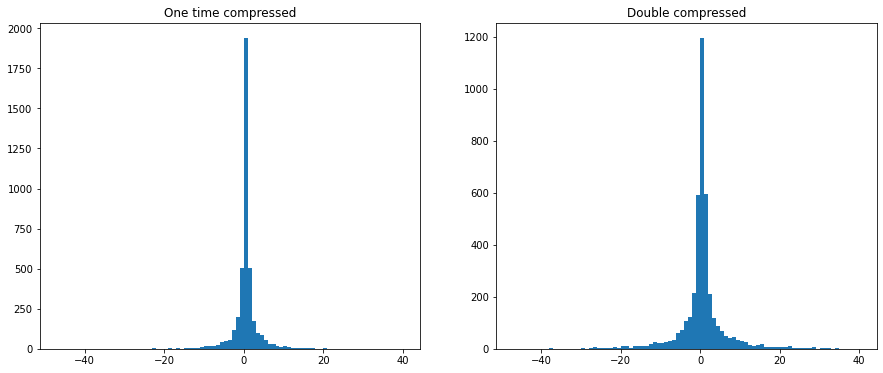

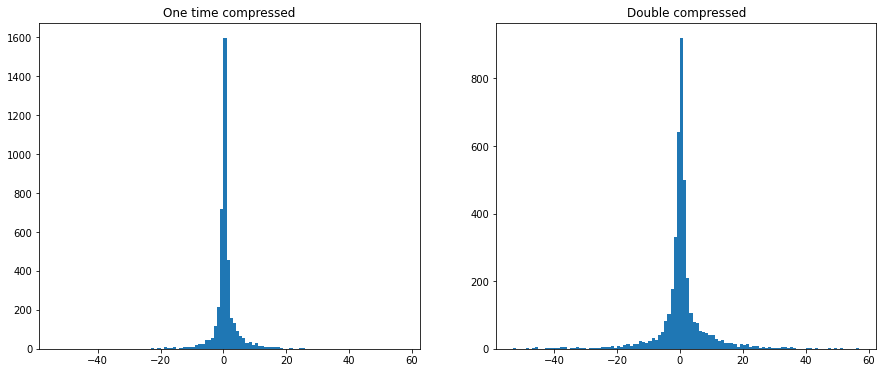

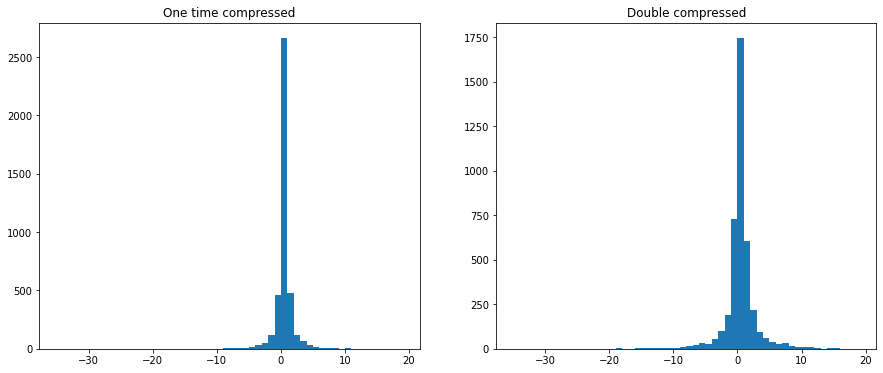

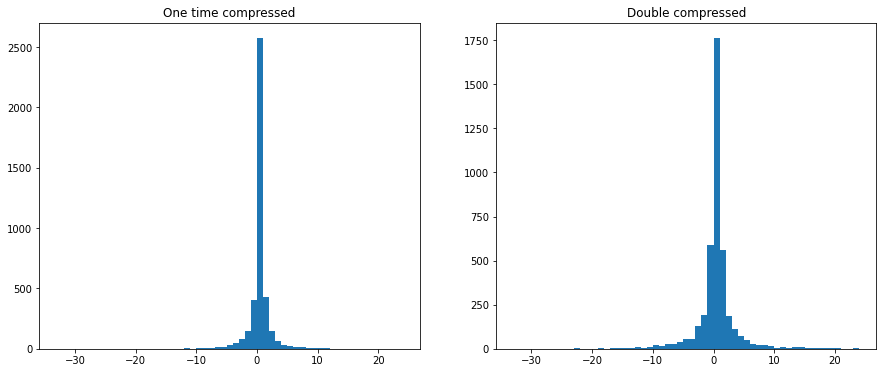

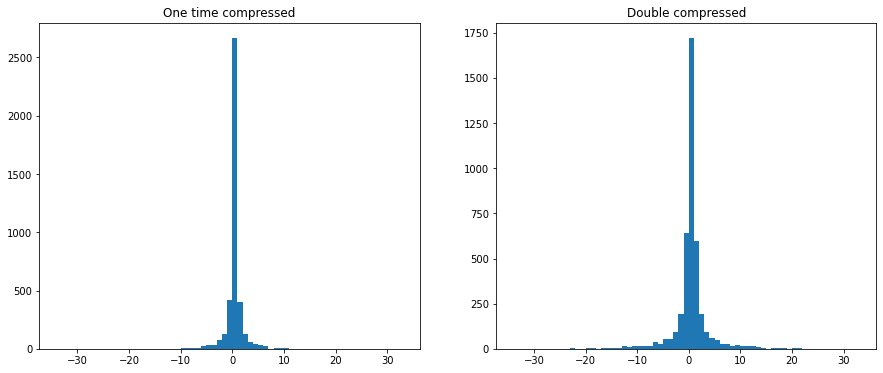

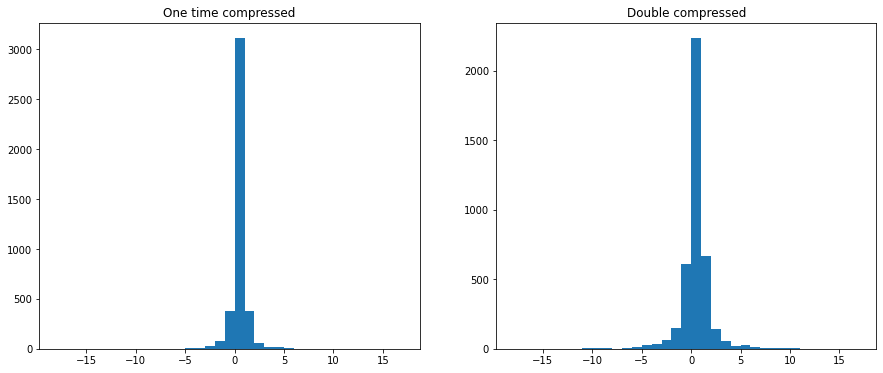

In [27]:
for i in range(10):
    min_dct = min(np.min(dct_quantized_coeff[i,:]),np.min(dct_quantized2_coeff[i,:]))
    max_dct = max(np.max(dct_quantized_coeff[i,:]),np.max(dct_quantized2_coeff[i,:]))
    x_bin = np.arange(min_dct,max_dct)
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.hist(dct_quantized_coeff[i , : ], x_bin)
    ax1.set_title("One time compressed")
    ax2.hist(dct_quantized2_coeff[i , : ], x_bin)
    ax2.set_title("Double compressed")
    plt.show()
    